## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

## 1: Introduction

## 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [ ]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 32.1 MB/s 
     |████████████████████████████████| 212 kB 73.8 MB/s 


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.9.2


## 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [ ]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [ ]:
tweets, labels = get_tweet(train)

In [ ]:
tweets[0] , labels[0]

('i didnt feel humiliated', 'sadness')

## 4: Tokenizer

1. Tokenizing the tweets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words = 10000, oov_token='<UNK>')  #Anything that is not present in those most frequent 10,000 words in tokenized as 'UNK'
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [ ]:
tweets[0]

'i didnt feel humiliated'

## 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

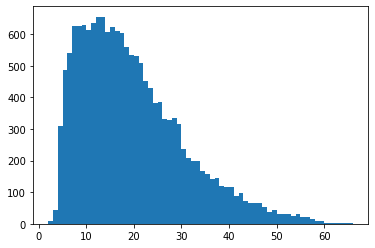

In [ ]:
lengths = [len(t.split()) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

## Most of the lengths lie between 10-20 length

In [ ]:
maxlen = 50 

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating = 'post', padding='post', maxlen = maxlen)
  return padded

##This way all the tweets will be of the same length (helps in specifying the input shape)

In [ ]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [ ]:
padded_train_seq[0]

##same as tweets[0] just the padding has been done here

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [ ]:
classes =  set(labels)
print(classes)

{'surprise', 'sadness', 'anger', 'love', 'fear', 'joy'}


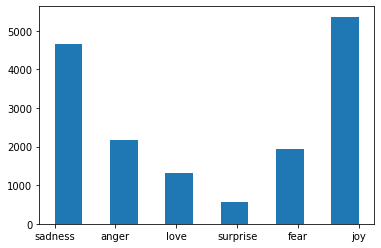

In [ ]:
plt.hist(labels, bins = 11)
plt.show()

In [ ]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [ ]:
class_to_index

{'surprise': 0, 'sadness': 1, 'anger': 2, 'love': 3, 'fear': 4, 'joy': 5}

In [ ]:
index_to_class

{0: 'surprise', 1: 'sadness', 2: 'anger', 3: 'love', 4: 'fear', 5: 'joy'}

In [ ]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[0])

1


## 7: Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
##Using Sequential Class from Keras

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length= maxlen),                           #input dim=10,000 | output dim=16 means each word is going to be a 16 dimensional vector 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),        #context in LSTM can go both left to right and right to left | return sequences True means every time step we will have an output
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')                          #6 for the 6 output classes that we have 
])

model.compile(
    
    loss = 'sparse_categorical_crossentropy',     #for multiclass we use categorical cross entropy and since these values were not OHE, we use sparse categorical cross entropy
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## 8: Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 1)

In [ ]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)  #if model doesn't see improvement in accuracy for 2 consecutive epochs, the training will stop
    ]
)

Epoch 1/20
500/500 [==============================] - 20s 20ms/step - loss: 1.2495 - accuracy: 0.5086 - val_loss: 0.7554 - val_accuracy: 0.7210
Epoch 2/20
500/500 [==============================] - 8s 15ms/step - loss: 0.5180 - accuracy: 0.8037 - val_loss: 0.4891 - val_accuracy: 0.8300
Epoch 3/20
500/500 [==============================] - 9s 19ms/step - loss: 0.3009 - accuracy: 0.8966 - val_loss: 0.4274 - val_accuracy: 0.8615
Epoch 4/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1838 - accuracy: 0.9406 - val_loss: 0.3575 - val_accuracy: 0.8715
Epoch 5/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1524 - accuracy: 0.9501 - val_loss: 0.3654 - val_accuracy: 0.8770
Epoch 6/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1167 - accuracy: 0.9619 - val_loss: 0.3765 - val_accuracy: 0.8850
Epoch 7/20
500/500 [==============================] - 6s 12ms/step - loss: 0.0875 - accuracy: 0.9728 - val_loss: 0.4178 - val_accuracy: 0.881

## 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

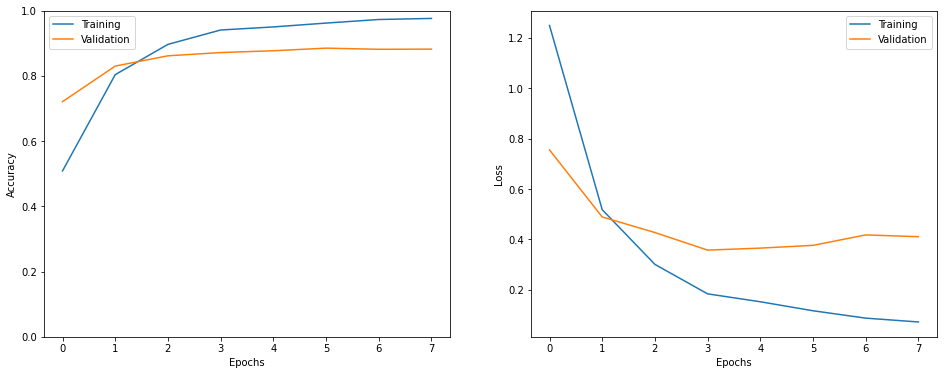

In [ ]:
show_history(h)

In [ ]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.3967 - accuracy: 0.8810


In [ ]:
i = random.randint(0, len(test_labels)-1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])      


p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]    #np.expand_dims(test_seq[2], axis = 0).shape = (1,50)
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)


Sentence: i feel is that the most likeable characters aren t important enough to the plot
Emotion: joy
1/1 [==============================] - 0s 76ms/step
Predicted Emotion: joy


In [ ]:
preds = np.argmax(model.predict(test_seq), axis=-1)

63/63 [==============================] - 0s 7ms/step


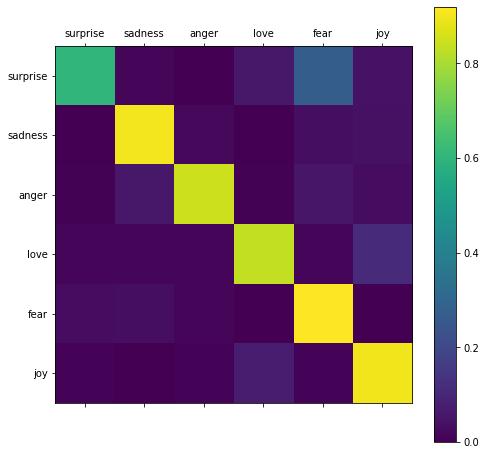

In [ ]:
show_confusion_matrix(test_labels, preds, list(classes))